This script is a first experiment in analyzing multi-hazard impacts on the power grid

It uses the following approach:
- Identify power grid disturbances across power grid data sets
- Identify periods of 'extreme' disruption
- Selects data in a given area of interest from three hazards
    - wildfire
    - space weather
    - terrestrial weather (wind, precipitation, rain)
- Visualizes everything on a map
- Identifies simple compounding connections (same space and time)


Start with time periods
- 2014-2016 (balance of availability in power grid outage data, space weather activity, GIC data)


Start with area of interest
- California


In [30]:
import numpy as np
import pandas as pd
import os, sys

import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


### Power grid disturbance data

Candidates
- [new dataset from EAGLE-I](https://www.nature.com/articles/s41597-024-03095-5) (Data are available in the Figshare repository at https://doi.org/10.6084/m9.figshare.24237376) 
- [DOE electric disturbance events OE-417](https://www.oe.netl.doe.gov/OE417_annual_summary.aspx)


In [15]:
# Read in 2014 data
outage_directory = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/outage_data/'
oe417 = pd.read_excel(os.path.join(outage_directory,'DOE-OE-417/2014_Annual_Summary.xlsx'),header=1)
oe417 = oe417.dropna(subset=['Time Event Began'])
oe417 = oe417.iloc[:-2]
# eaglei = pd.read_csv(os.path.join(outage_directory,'EAGLE-I/eaglei_outages_2014.csv'))


In [16]:
oe417

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Event Type,Demand Loss (MW),Number of Customers Affected
1,2014-01-06 00:00:00,19:50:00,2014-01-06 00:00:00,20:44:00,District of Columbia,RFC,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown
2,2014-01-06 00:00:00,19:50:00,2014-01-06 00:00:00,20:44:00,Unknown,RFC,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown
3,2014-01-06 00:00:00,19:52:00,2014-01-06 00:00:00,20:45:00,Delaware,RFC,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown
4,2014-01-06 00:00:00,20:45:00,2014-01-07 00:00:00,21:00:00,Unknown,RFC,Public Appeal due to Severe Weather - Cold,Unknown,Unknown
5,2014-01-06 00:00:00,19:50:00,2014-01-06 00:00:00,20:49:00,Pennsylvania,RFC,Voltage Reduction due to Severe Weather - Cold,200,62000
...,...,...,...,...,...,...,...,...,...
219,2014-12-11 00:00:00,07:21:00,2014-12-11 00:00:00,21:53:00,"San Francisco, California",WECC,Distribution Interruption - Unknown Cause,225,75000
220,2014-12-11 00:00:00,23:15:00,Unknown,Unknown,Northern California,WECC,Severe Weather- High Winds,Unknown,Unknown
221,2014-12-11 00:00:00,16:05:00,2014-12-11 00:00:00,21:00:00,"Portland, Oregon",WECC,Severe Weather- High Winds,250,85470
222,2014-12-11 00:00:00,17:00:00,2014-12-12 00:00:00,10:00:00,"Kitsap, Thurston, Whatcom counties Washington",WECC,Severe Weather- High Winds,116,264000


In [36]:
oe417 = oe417[oe417['Area Affected'].str.contains('California')]

In [20]:
eaglei = eaglei[eaglei['state'] == 'California']

In [25]:
for o in range(len(oe417['Number of Customers Affected'])):
    if oe417['Number of Customers Affected'].iloc[o]=='Unknown':
        oe417['Number of Customers Affected'].iloc[o] = np.nan
    
        

In [27]:
# Apply severity filters
oe417 = oe417[oe417['Number of Customers Affected']>1000]
eaglei = eaglei[eaglei['customers_out']>1000]


In [61]:
# Identify spatial areas of these candidate events (define the bounds of them as the regions they 
#   covered and consruct geopandas dataframes for them)

# oe417
gdf_states = gpd.read_file('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/location_data/Census_Bureau_Data/tl_2014_us_state/tl_2014_us_state.shp')
gdf_counties = gpd.read_file('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/location_data/Census_Bureau_Data/tl_2014_us_county/tl_2014_us_county.shp')



In [45]:
state = oe417['Area Affected'].iloc[-1]
state

'San Francisco, California'

13    MULTIPOLYGON (((-119.63472 33.26544, -119.6363...
Name: geometry, dtype: geometry


<Axes: >

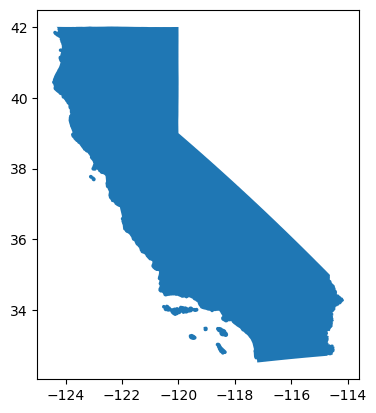

In [52]:
# Filter the GeoDataFrame by state name (example for 'California')
state_polygon = gdf_states[gdf_states['NAME'] == 'California']

# Display the polygon geometry
print(state_polygon.geometry)

state_polygon.plot()

In [64]:
gdf_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,NaN,NaN,NaN,A,1477895771,10447356,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,NaN,NaN,NaN,A,682138834,61658247,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,NaN,NaN,NaN,A,6015540562,29159485,+34.3592729,-104.3686961,"POLYGON ((-104.56746 33.99739, -104.57710 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,NaN,A,2169240148,22877213,+40.7835474,-096.6886584,"POLYGON ((-96.91060 40.95841, -96.91060 40.958..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,NaN,NaN,NaN,A,1489645230,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,NaN,NaN,NaN,A,1103983746,12186867,+34.6904951,-084.4546507,"POLYGON ((-84.65478 34.66559, -84.65488 34.669..."
3229,27,135,00659513,27135,Roseau,Roseau County,06,H1,G4020,NaN,NaN,NaN,A,4329419259,16925440,+48.7610683,-095.8215042,"POLYGON ((-96.40466 48.80528, -96.40467 48.813..."
3230,28,089,00695768,28089,Madison,Madison County,06,H1,G4020,298,27140,NaN,A,1850054742,71147843,+32.6343703,-090.0341603,"POLYGON ((-90.09363 32.70763, -90.09360 32.707..."
3231,48,227,01383899,48227,Howard,Howard County,06,H1,G4020,NaN,13700,NaN,A,2333038504,8841705,+32.3034712,-101.4387720,"POLYGON ((-101.69227 32.27106, -101.69221 32.2..."


636    MULTIPOLYGON (((-122.60024 37.80248, -122.6122...
Name: geometry, dtype: geometry


<Axes: >

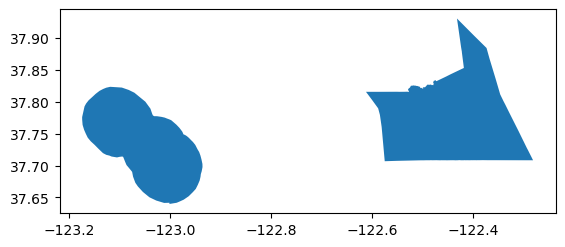

In [65]:
# Filter by both state and county name (example for 'Los Angeles County' in 'California')
county_polygon = gdf_counties[(gdf_counties['STATEFP'] == '06') & (gdf_counties['COUNTYFP']=='075')]

# Display the polygon geometry
print(county_polygon.geometry)

county_polygon.plot()

### Power grid physical network
Get the data and limit to the area affected by the outage (right now only manually gets the California power grid data)

In [ ]:
file_path = "/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/physical_grid_data/U.S._Electric_Power_Transmission_Lines.geojson"
gdf = gpd.read_file(file_path)
# gdf = gdf.to_crs(epsg=3857)
# gdf = gdf.to_crs(epsg=4326)

 

# Convert timeframes to folium-friendly types
gdf['SOURCEDATE'] = pd.to_datetime(gdf['SOURCEDATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')
gdf['VAL_DATE'] = pd.to_datetime(gdf['VAL_DATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')


In [ ]:
# Load California shape file
ca_boundaries_file = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/location_data/ca_state/CA_State.shp'
ca_boundaries = gpd.read_file(ca_boundaries_file)
    
    
ca_boundaries = ca_boundaries.to_crs('EPSG:4326')


In [ ]:
# Assuming your GeoPandas DataFrame is named 'gdf', filter the data within California
data_within_california = gdf[gdf.geometry.within(ca_boundaries.geometry.iloc[0])]

# # Plot the data within California
# ax = ca_boundaries.plot(color='lightgray', edgecolor='black')
# data_within_california.plot(ax=ax, color='blue', markersize=5)

map = data_within_california.plot(figsize=(20, 16),linewidth=0.5)

# Define common voltages and corresponding colors
common_voltages = [0, 44, 115, 161, 169, 230, 345]

hex_colors = ['blue','green', 'cyan', 'yellow', 'orange', 'red']
legend_labels = ['<' + str(i) for i in common_voltages[1:]]

# Plot overlays for each common voltage
for voltage, color, label in zip(common_voltages, hex_colors, legend_labels):
    overlay = data_within_california[data_within_california['VOLTAGE'] > voltage]  # Filter GeoDataFrame based on voltage
    overlay.plot(ax=map, marker='o', color=color, markersize=5, linewidth=0.5, label=label)
    
# Create a custom legend with colored patches
legend_handles = [Patch(color=color, label=label) for color, label in zip(hex_colors, legend_labels)]

# Add legend
map.legend(handles=legend_handles, title='Voltage', loc='upper right')

# Set xy axis limits
map.set_xlim((-127, -105))
map.set_ylim((30,45))

# Put labels on the map
map.set_xlabel("Longitude")
map.set_ylabel("Latitude")
map.set_title("Major California Transmission Lines")


### Space Weather data

Candidates
- substorms events lists
- supermag optimally interpolated maps
- areas of aurora
- magnetometers in AoI above thresholds
- GICs directly



For now exploring, manually, a potential connection between concurrent space weather and Camp Fire events (November 8, 2018)


In [11]:
spwx_dir = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20180825/'
GIC_ids = ['10116','10113','10119']
location_data = pd.read_csv(os.path.join(spwx_dir,'GIC/gic_monitors.csv'))
filtered_data = location_data[location_data['Device ID'].astype(str).isin(GIC_ids)]

# Display the filtered data to ensure the correct rows are selected
print(filtered_data[['Device ID', ' Latitude', ' Longitude']])




    Device ID   Latitude   Longitude
72      10113       45.6       121.1
75      10116       47.9       121.9
77      10119       47.5       120.3


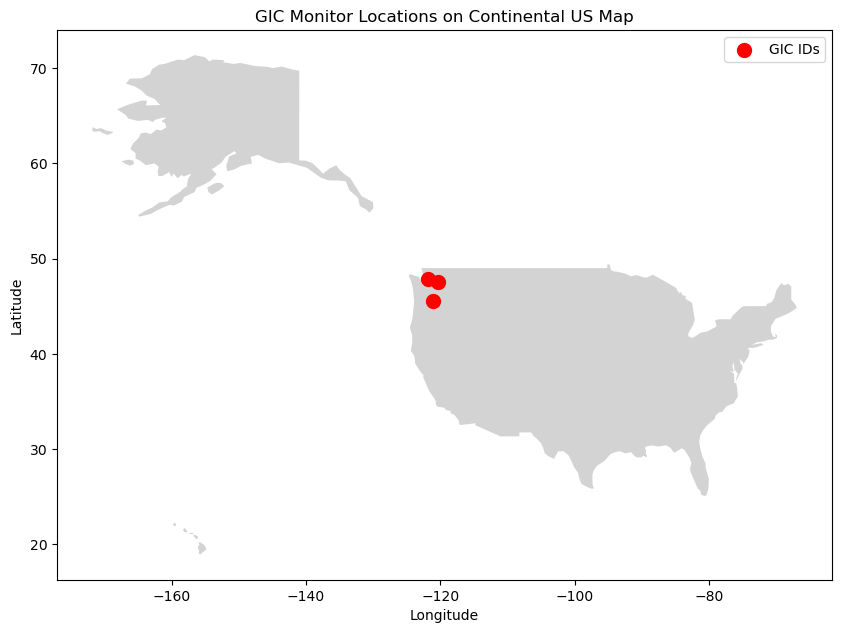

In [16]:
# Load a shapefile of the continental US (or download one)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter to the continental US (excludes Alaska and Hawaii)
us_map = world[(world.name == "United States of America")]

# Plot the continental US
fig, ax = plt.subplots(figsize=(10, 8))
us_map.plot(ax=ax, color='lightgray')

# Plot the filtered GIC IDs
ax.scatter(filtered_data[' Longitude']*-1, filtered_data[' Latitude'], color='red', s=100, label='GIC IDs')

# Add labels and title
plt.title('GIC Monitor Locations on Continental US Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()


/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20180825/GIC/2018E01_10116.csv
/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20180825/GIC/2018E01_10113.csv
/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20180825/GIC/2018E01_10119.csv


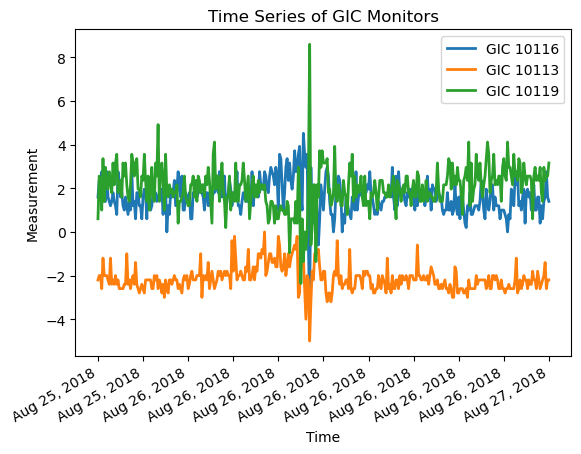

In [31]:
gic_data = pd.DataFrame()
for g in GIC_ids:
    file_tmp = os.path.join(spwx_dir,'GIC/2018E01_'+g+'.csv')
    print(file_tmp)
    data_tmp = pd.read_csv(file_tmp)
    gic_data[g] = data_tmp['GICMeasured']
    gic_data[g+' datetime'] = data_tmp['SampleDateTime']
    gic_data[g+' datetime'] = pd.to_datetime(gic_data[g+' datetime'], format='%m/%d/%Y %I:%M:%S %p')
    gic_data
    
    # Plot the time series
    plt.plot(gic_data[g+' datetime'], gic_data[g], label=f'GIC {g}', linewidth=2)

# Format the x-axis to handle datetime intelligently
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjust date ticks
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.AutoDateLocator()))  # Format date labels
# Set custom date format (e.g., 'Month-Day Year')
ax.xaxis.set_major_formatter(DateFormatter('%b %d, %Y'))


# Rotate date labels to avoid overlap
plt.gcf().autofmt_xdate()

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Time Series of GIC Monitors')
plt.legend()



# Display the plot
plt.show()

In [28]:
gic_data['10116 datetime'][0]

'8/25/2018 6:00:00 PM'

### Terrestrial Weather data

### Wildfire data

### Visualize spatial areas on common map